In [1]:
import numpy as np
import glob, os, sys
import xarray as xr
import pandas as pd
import time, datetime, calendar, pytz
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
datadir = '/gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/taranis_corcsapr2cfrppiqcM1_gridded.c1/'
figdir = '/gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.v2/figures/compref_demo/'
os.makedirs(figdir, exist_ok=True)

terrain_file = f'/gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/corgridded_terrain.c0/CSAPR2_Taranis_Gridded_500m.Terrain_RangeMask.nc'

filelist = sorted(glob.glob(f'{datadir}/*20181111.00*.nc'))
print(f'Found {len(filelist)} files.')
test_file_idx = 2
filename_1 = filelist[test_file_idx]

print(f'Starting with file: {filename_1}')

Found 4 files.
Starting with file: /gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/taranis_corcsapr2cfrppiqcM1_gridded.c1/taranis_corcsapr2cfrppiqcM1.c1.20181111.003003_gridded.nc


In [3]:
ds = xr.open_dataset(filename_1)

# Create time_coords
time_coords = ds.time
out_ftime = time_coords.dt.strftime("%Y%m%d.%H%M%S").item()
# import pdb; pdb.set_trace() 

x_dimname = 'x'
y_dimname = 'y'
z_dimname = 'z'
y_varname = 'y'
x_varname = 'x'
z_varname = 'z'
reflectivity_varname = 'taranis_attenuation_corrected_reflectivity'
sfc_dz = 500.

# Get data coordinates and dimensions
height = ds[z_dimname].squeeze().values
nx = ds.sizes[x_dimname]
ny = ds.sizes[y_dimname]
nz = ds.sizes[z_dimname]
y_coords = ds[y_varname]
x_coords = ds[x_varname]
# time_coords = ds.time
radar_lon = ds.origin_longitude
radar_lat = ds.origin_latitude
grid_lon = ds.point_longitude.isel(z=0)
grid_lat = ds.point_latitude.isel(z=0)

# Change radar height coordinate from AGL to MSL
z_agl = ds[z_dimname] + 1141
ds[z_dimname] = z_agl

In [4]:
# Read terrain file
dster = xr.open_dataset(terrain_file)

# Change terrain file dimension name to be consistent with radar file
# dster = dster.rename({'latdim':y_dimname, 'londim':x_dimname})
# Assign coordinate from radar file to the terrain file so they have the same coordinates
dster = dster.assign_coords({y_dimname:(ds[y_varname]), x_dimname:(ds[x_varname])})
sfc_elev = dster.hgt

In [5]:
# Get radar variables
dbz3d = ds[reflectivity_varname].squeeze()
ncp = ds.normalized_coherent_power.squeeze()

# Some combination of masks may be better to apply here to filter out bad signals
# including clutter, second trip, low signal side lobes
# but when this program was written, that optimal combination was not yet determined
# and one needs to be careful not to remove good echoes
# This NCP filter works well as a substitute
dbz3d = dbz3d.where(ncp >= 0.5)

# Filter reflectivity below certain elevation height
dbz3d_filt = dbz3d.where(ds[z_varname] > (sfc_elev + sfc_dz))
# Filter reflectivity outside the low-level
dbz3d_lowlevel = dbz3d.where((ds[z_varname] >= sfc_dz) & (ds[z_varname] <= 1300))

# Get composite reflectivity 
dbz_comp = dbz3d_filt.max(dim=z_dimname)
# Get low-level composite reflectivity
dbz_lowlevel = dbz3d_lowlevel.max(dim=z_dimname)

In [6]:
timestr = ds.time.squeeze().dt.strftime("%Y-%m-%d %H:%M UTC").data
fignametimestr = ds.time.squeeze().dt.strftime("%Y%m%d_%H%M").data.item()
fignametimestr

'20181111_0030'

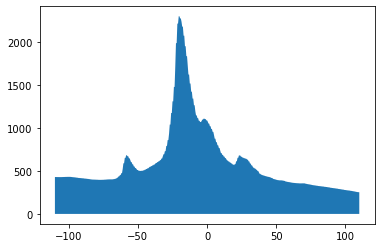

In [7]:
sfc_elev_c90 = sfc_elev.sel(y=0)
plt.fill_between(x_coords/1000, 0, sfc_elev_c90)

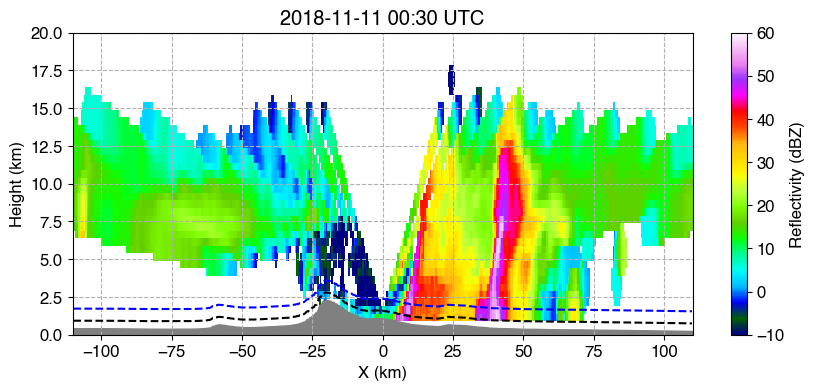

In [8]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Helvetica'
fig, ax = plt.subplots(1,1, figsize=[10,4], dpi=100)

dbz_c90 = dbz3d.sel(y=0)
pcm = ax.pcolormesh(x_coords/1000, z_agl/1000, dbz_c90, vmin=-10, vmax=60, cmap='gist_ncar')
ter = ax.fill_between(x_coords/1000, 0, sfc_elev_c90/1000, color='gray')
ter500 = ax.plot(x_coords/1000, (sfc_elev_c90+sfc_dz)/1000, color='k', ls='--', lw=1.5)
ter500 = ax.plot(x_coords/1000, (sfc_elev_c90+1300)/1000, color='b', ls='--', lw=1.5)
cbar = plt.colorbar(pcm, label='Reflectivity (dBZ)')
ax.set_ylim(0, 20)
ax.set_ylabel('Height (km)')
ax.set_xlabel('X (km)')
ax.set_title(timestr)
ax.grid(ls='--')

figname = figdir + fignametimestr + '_cross90deg.png'
fig.savefig(f'{figname}', dpi=300, bbox_inches='tight')

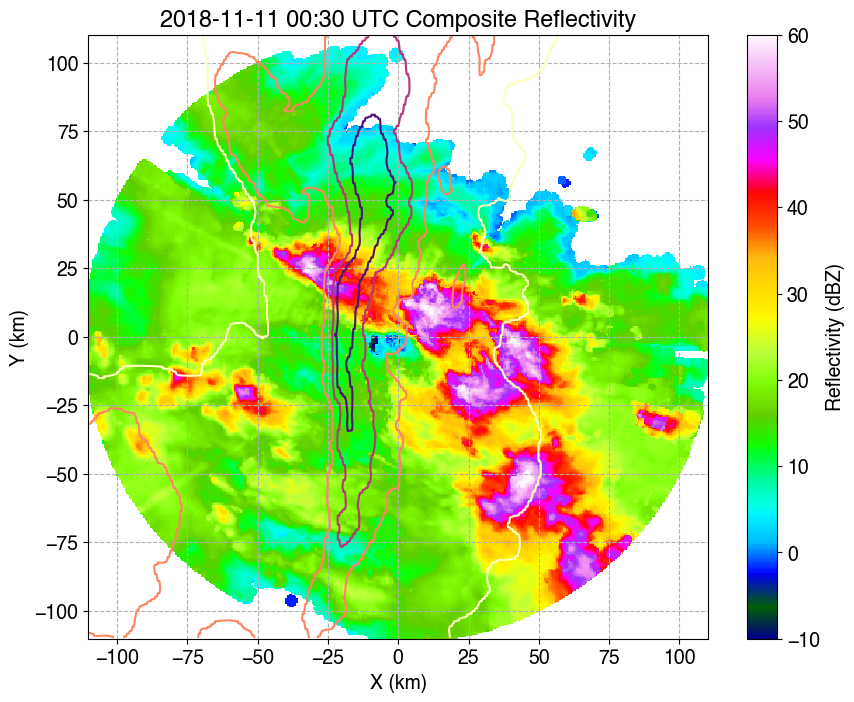

In [9]:
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Helvetica'
fig, ax = plt.subplots(1,1, figsize=[10,8], dpi=100)

topo_levs = [500, 1000, 1500, 2000, 2500]
cmap_topo = 'magma_r'

dbz_c90 = dbz3d.sel(y=0)
pcm = ax.pcolormesh(x_coords/1000, y_coords/1000, dbz_comp, vmin=-10, vmax=60, cmap='gist_ncar')
ter = ax.contour(x_coords/1000, y_coords/1000, sfc_elev, levels=topo_levs, cmap=cmap_topo, linewidths=1.5)
cbar = plt.colorbar(pcm, label='Reflectivity (dBZ)')
# ax.set_ylim(0, 20)
ax.set_ylabel('Y (km)')
ax.set_xlabel('X (km)')
ax.set_title(timestr + ' Composite Reflectivity')
ax.grid(ls='--')

figname = figdir + fignametimestr + '_compref.png'
fig.savefig(f'{figname}', dpi=300, bbox_inches='tight')

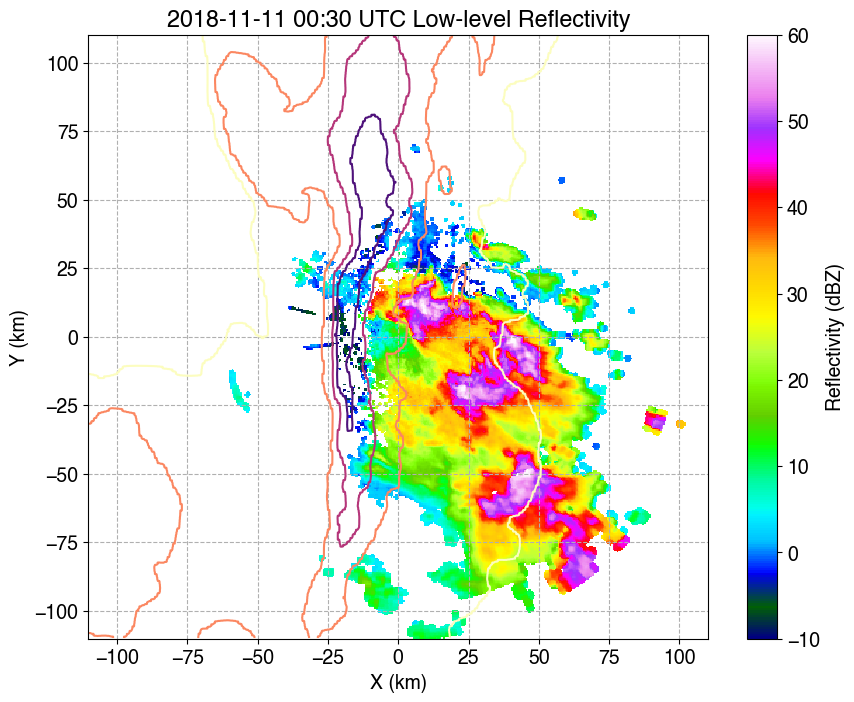

In [10]:
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Helvetica'
fig, ax = plt.subplots(1,1, figsize=[10,8], dpi=100)

topo_levs = [500, 1000, 1500, 2000, 2500]
cmap_topo = 'magma_r'

dbz_c90 = dbz3d.sel(y=0)
pcm = ax.pcolormesh(x_coords/1000, y_coords/1000, dbz_lowlevel, vmin=-10, vmax=60, cmap='gist_ncar')
ter = ax.contour(x_coords/1000, y_coords/1000, sfc_elev, levels=topo_levs, cmap=cmap_topo, linewidths=1.5)
cbar = plt.colorbar(pcm, label='Reflectivity (dBZ)')
# ax.set_ylim(0, 20)
ax.set_ylabel('Y (km)')
ax.set_xlabel('X (km)')
ax.set_title(timestr + ' Low-level Reflectivity')
ax.grid(ls='--')

figname = figdir + fignametimestr + '_lowlevelrefl.png'
fig.savefig(f'{figname}', dpi=300, bbox_inches='tight')

In [11]:
figdir

'/gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.v2/figures/compref_demo/'